In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

import matplotlib.pyplot as plt
import itertools

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## VAE Model

In [2]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h = self.relu(self.fc1(x))
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        h = self.relu(self.fc2(z))
        recon = self.sigmoid(self.fc3(h))
        return recon

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        recon = self.decode(z)
        return recon, mean, logvar

## Loss function, plot loss function, Train function

In [3]:
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.MSELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [4]:
def train(model, dataloader, optimizer, num_epochs):
    loss_log = []
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        with tqdm(dataloader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
            for batch_idx, (data, _) in enumerate(tepoch):
                data = data.view(-1, 784)
                optimizer.zero_grad()
                recon_batch, mean, logvar = model(data)
                loss = loss_function(recon_batch, data, mean, logvar)
                loss.backward()
                total_loss += loss.item()
                optimizer.step()
                tepoch.set_postfix(loss=total_loss / ((batch_idx + 1) * dataloader.batch_size))
        loss_log.append(total_loss / len(dataloader.dataset))
    print(f"Training finished.")
    return loss_log


In [5]:
def plot_training_loss(losses, save_path=None):
    plt.figure(figsize=(8, 6))
    plt.plot(losses, label='Training Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

## Dataset

In [6]:
batch_size = 128

# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load MNIST training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_set = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 25393717.27it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 28910666.78it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 6670999.02it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4510068.36it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



## Train Loop

In [79]:
# Assuming you have a DataLoader named train_loader with your training data
num_epochs = 200  # You can adjust the number of epochs
input_dim = 784  # Change this according to your input data dimension
hidden_dim = 400
latent_dim = 60
plot_len = 8
lr = 1e-3

model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [80]:
losses = train(model, train_loader, optimizer, num_epochs)

Epoch 200/200: 100%|██████████| 547/547 [00:17<00:00, 31.68batch/s, loss=27.7]

Training finished.


In [81]:
torch.save(model.state_dict(), "model_weight/VAE weights.pth")

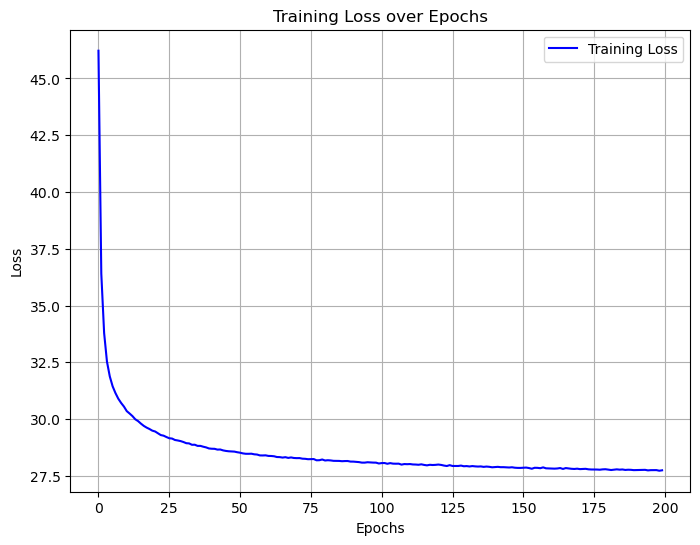

In [82]:
plot_training_loss(losses, 'VAE_loss.png')

## Generate images

In [83]:
def generate_samples(model, num_samples):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim)
        samples = model.decode(z)
    return samples.reshape(-1, 28, 28), z

In [84]:
def decode_latents(model, zs):
    images = []
    model.eval()
    with torch.no_grad():
        for z in zs:
            images.append(model.decode(z))
    return images

In [85]:
def visualize_images(images, width=8, figwidth=10):
    fig, axes = plt.subplots(width, width, figsize=(figwidth, figwidth))
    for i in range(width):
        for j in range(width):
            axes[i, j].imshow(images[i * width + j].cpu().view(28, 28), cmap='gray')
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.savefig("vae64.png")
    plt.show()

## Pick four samples from the latent space

In [86]:
# Load the model
model.load_state_dict(torch.load("model_weight/VAE weights.pth"))

<All keys matched successfully>

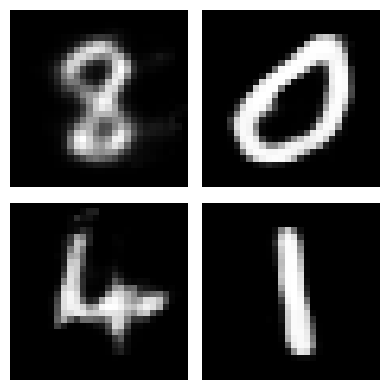

tensor([[-0.3857,  0.5083,  2.4022, -1.6242,  0.1636, -0.0135,  0.4915,  0.2316,
         -0.3060,  0.0401,  0.1210,  0.3520, -0.7771,  0.9020, -1.0541,  0.9452,
          1.1183,  0.2014, -1.1626, -0.5208, -0.1671,  1.4096, -1.3217, -0.7189,
          0.2674, -1.4378, -2.1204, -0.7492, -0.3003, -0.4149, -1.6520, -0.6328,
          0.5926, -0.0301,  0.1531,  0.2212,  0.5934, -0.6448, -0.0053,  0.8006,
         -0.7300,  0.5429,  0.5522, -0.1833, -0.4084, -0.5822, -0.2576,  0.5918,
         -0.8010,  0.3667,  2.2310, -0.0916,  0.6443, -1.7838, -1.3704, -0.2283,
          0.7520,  0.4750,  0.3130,  1.0199],
        [ 1.5105,  0.6689,  0.5730, -0.9633,  0.8823,  1.2842, -2.3288,  0.1468,
         -0.9312, -0.6282, -0.9858,  0.5573,  0.1883, -1.0666, -1.6300,  0.3812,
          0.2230,  0.0732, -2.1853, -0.3387, -1.8085,  0.9645,  1.3778, -0.8010,
          2.4698, -1.8171, -0.2154,  1.1934,  1.5588, -0.1268, -0.4268,  2.1951,
         -1.8155, -1.0449, -0.0360, -0.3928, -1.3250,  1.1014, 

In [99]:
generated_samples, latents = generate_samples(model, 4)
visualize_images(generated_samples, 2, 4)
print(latents)

## Plot 8*8 images

In [88]:
def interpolate_four_corners(corners, width_count, height_count):
    top_left, top_right, bottom_left, bottom_right = corners
    sections = []
    for i in range(height_count):
        for j in range(width_count):
            alpha = i / height_count
            beta = j / width_count

            top = alpha * top_left + (1 - alpha) * top_right
            bottom = alpha * bottom_left + (1 - alpha) * bottom_right

            interpolated_vector = beta * top + (1 - beta) * bottom
            sections.append(interpolated_vector)
    return sections

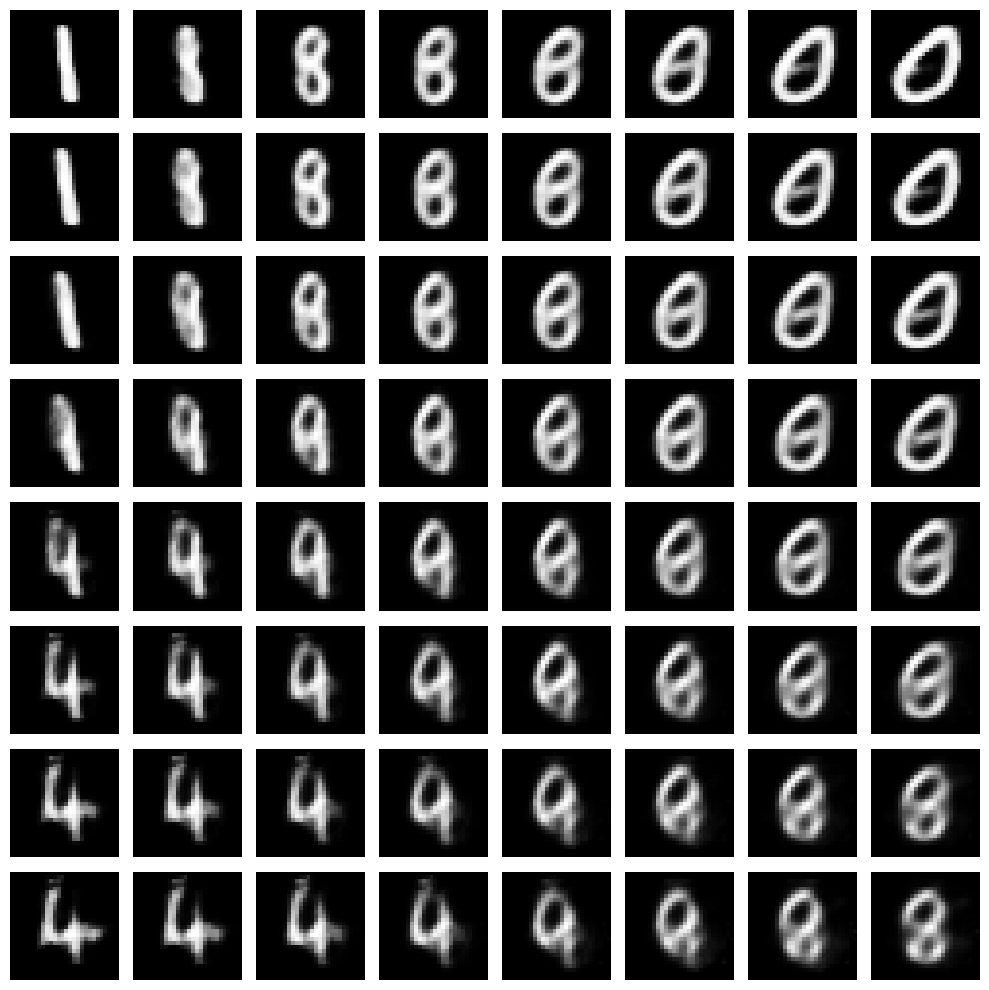

In [100]:
inter_latents = interpolate_four_corners(latents, 8, 8)
inter_images = decode_latents(model, inter_latents)
visualize_images(inter_images, 8)